In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("../data/perrin-frerus.csv")
data.head()

,"Month,Perrin Freres monthly champagne sales millions ?64-?72"
0,"1964-01,2815"
1,"1964-02,2672"
2,"1964-03,2755"
3,"1964-04,2721"
4,"1964-05,2946"


In [3]:
data[["Month", "Sales"]] = data["Month,Perrin Freres monthly champagne sales millions ?64-?72"].str.split(",",n=1, expand=True)

data.head()

,"Month,Perrin Freres monthly champagne sales millions ?64-?72",Month,Sales
0,"1964-01,2815",1964-01,2815
1,"1964-02,2672",1964-02,2672
2,"1964-03,2755",1964-03,2755
3,"1964-04,2721",1964-04,2721
4,"1964-05,2946",1964-05,2946


In [4]:
data = data.drop("Month,Perrin Freres monthly champagne sales millions ?64-?72", axis=1)
data.describe()

,Month,Sales
count,107,107
unique,107,104
top,1967-05,
freq,1,2


In [5]:
data.replace("",np.nan, inplace=True)
data.dropna(axis=0,inplace=True)
data.describe()

,Month,Sales
count,105,105
unique,105,103
top,1967-05,3523
freq,1,2


In [6]:
data["Month"] = pd.to_datetime(data["Month"])
data.set_index("Month", inplace=True)
data.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


<hr>

## Data Visualisation

<hr>

Steps to visualise time series data:
    * Convert time series data to pandas datetime
    * Make datetime as index
    * Convert the data column to float or int format
    * Plot the data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Sales   105 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


In [8]:
data["Sales"] = data["Sales"].astype("int")
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   105 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


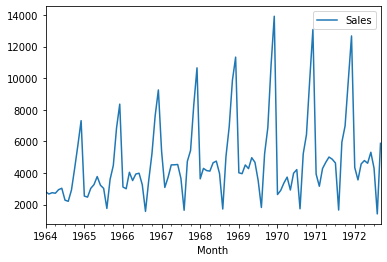

In [9]:
import matplotlib.pyplot as plt

data.plot()

<hr>

## Checking for Stationarity

<hr>

<pre>
We use Dickey-Fuller test to check for stationarity in data.

ARIMA:
    * Auto Regressive - Depends on previous terms.  - p
    * Integrated - Difference with lagged data.     - d
    * Moving Average - Taking multiple error terms of lags.   - q
    
Dickey-Fuller test:

It assumes null hypothesis as data is non stationary.

H0 : Null Hypothesis : Data is non stationary.
H1 : Alternate Hypothesis : Data is stationary.

if p-value <= 0.05:
    Accept Alternate hypothesis.
else:
    Accept Null Hypothesis.
    
</pre>

In [10]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ["ADF Test Statistic", "p-value", "No. of Lags", "No. of observations"]
    results_dict = dict()
    for val, label in zip(result, labels):
        results_dict[label] = val
        
    if results_dict["p-value"] <= 0.05:
        print("Reject Null Hypothesis. Data is stationary.")
        
    else:
        print("Accept Null Hypothesis. Data is not stationary.")
        
    print(results_dict)
    

In [11]:
adfuller_test(data["Sales"])

Accept Null Hypothesis. Data is not stationary.
{'ADF Test Statistic': -1.8335930563276193, 'p-value': 0.36391577166024686, 'No. of Lags': 11, 'No. of observations': 93}


If data is not stationary --> take log of data and difference with lagged data or take difference directly with lagged data.

<hr>

## Making data Stationary

<hr>

shift actually moves data by one time unit.

+ve --> Moves towards future.
-ve --> Moves towards past.

In [12]:
data["Sales Difference"] = data["Sales"] - data["Sales"].shift(1)

data.head()

,Sales,Sales Difference
Month,,
1964-01-01,2815,NaN
1964-02-01,2672,-143.0
1964-03-01,2755,83.0
1964-04-01,2721,-34.0
1964-05-01,2946,225.0


In [14]:
adfuller_test(data["Sales Difference"].dropna())

Reject Null Hypothesis. Data is stationary.
{'ADF Test Statistic': -7.189896448050998, 'p-value': 2.519620447387099e-10, 'No. of Lags': 11, 'No. of observations': 92}


<hr>

## Auto correlation and Partial Auto Correlation Plots

<hr>

/Users/i518758/Desktop/DeepLearning/deep381_env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


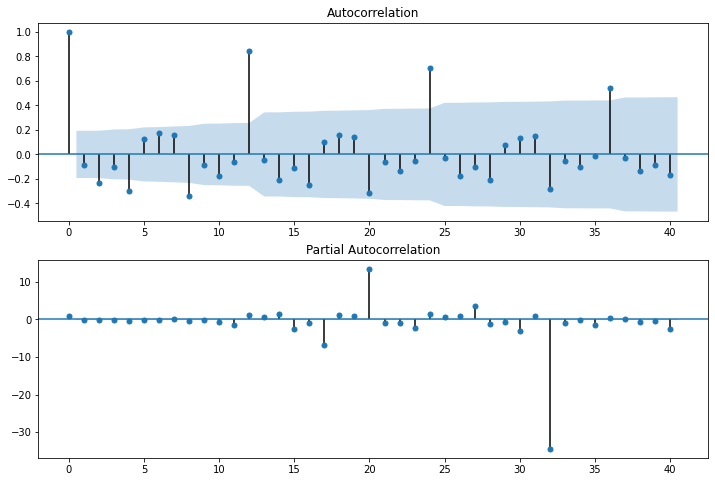

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data["Sales Difference"].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data["Sales Difference"].dropna(),lags=40,ax=ax2)

<hr>

## ARIMA 

<hr>

In [26]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(data["Sales Difference"].dropna(), order=(1,1,1))
r = model.fit()

r.summary()

/Users/i518758/Desktop/DeepLearning/deep381_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/i518758/Desktop/DeepLearning/deep381_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.Sales Difference   No. Observations:                  103
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -960.046
Method:                       css-mle   S.D. of innovations           2640.060
Date:                Fri, 15 May 2020   AIC                           1928.092
Time:                        11:21:25   BIC                           1938.631
Sample:                    03-01-1964   HQIC                          1932.361
                         - 09-01-1972                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.6640      7.987     -0.083      0.934     -16.319      14.991
ar.L1.D.Sales Difference    -0.0824      0.099     -0.829      0.407      -0.277       0.113
ma.L1.D.Sales Difference    -1.0000      0.024    -41.260      0.000      -1.048      -0.952
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -12.1318           +0.0000j           12.1318            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

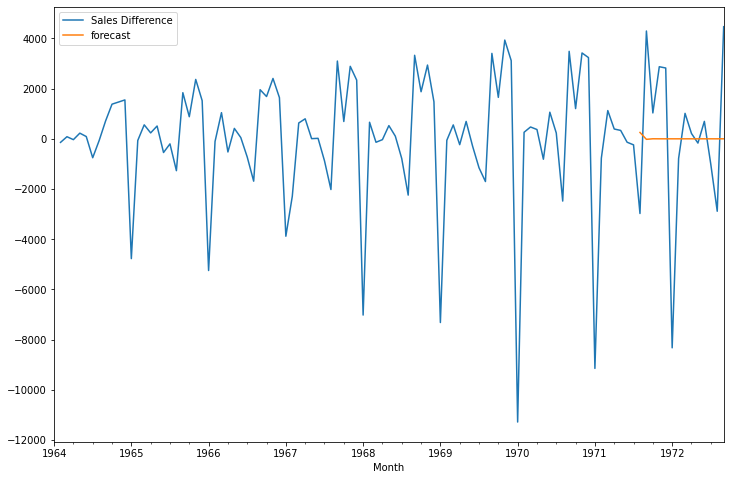

In [28]:
data["forecast"] = r.predict(start=90, end=103, dynamic=True)
data[["Sales Difference", "forecast"]].plot(figsize=(12,8))

<hr>

## SARIMAX

<hr>

In [30]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(data["Sales Difference"], order=(1,1,1),seasonal_order=(1,1,1,12))
r = model.fit()

/Users/i518758/Desktop/DeepLearning/deep381_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/i518758/Desktop/DeepLearning/deep381_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/i518758/Desktop/DeepLearning/deep381_env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [31]:
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   Sales Difference   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -750.690
Date:                            Fri, 15 May 2020   AIC                           1511.380
Time:                                    11:26:57   BIC                           1523.989
Sample:                                01-01-1964   HQIC                          1516.469
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3632      0.075     -4.852      0.000      -0.510      -0.216
ma.L1         -1.0000      0.574     -1.743      0.081      -2.125       0.125
ar.S.L12      -0.9940      0.148     -6.705      0.000      -1.285      -0.703
ma.S.L12       0.9395      0.736      1.277      0.202      -0.502       2.381
sigma2      6.131e+05   9.35e-07   6.55e+11      0.000    6.13e+05    6.13e+05
===================================================================================
Ljung-Box (Q):                       64.71   Jarque-Bera (JB):                11.84
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -0.49
Prob(H) (two-sided):                  0.32   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.68e+28. Standard errors may be unstable.
"""

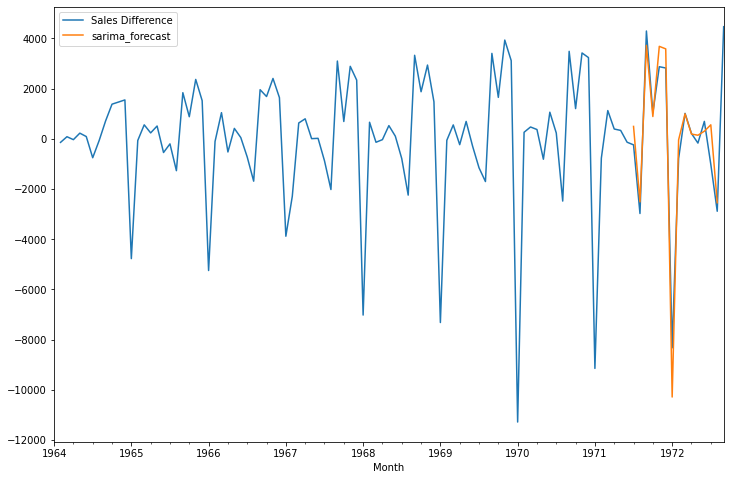

In [32]:
data['sarima_forecast']=r.predict(start=90,end=103,dynamic=True)
data[['Sales Difference','sarima_forecast']].plot(figsize=(12,8))

In [34]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)

future_df=pd.concat([data,future_datest_df])



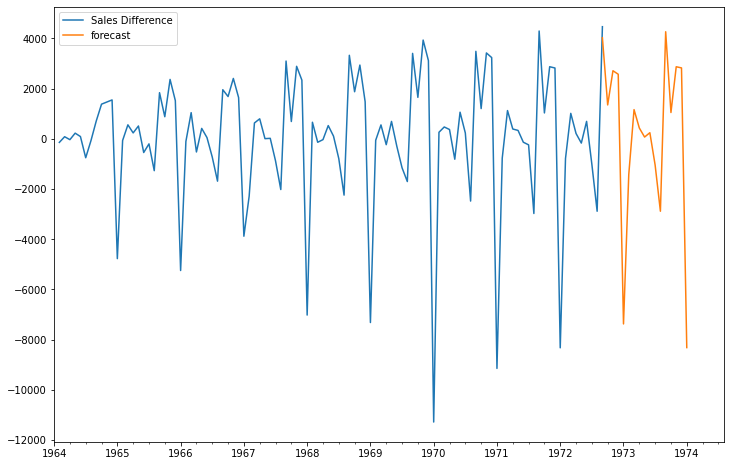

In [37]:
future_df['forecast'] = r.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales Difference', 'forecast']].plot(figsize=(12, 8))
